Size (MB)    | Eager (GB/s)    | Fused (GB/s)    | Speedup   
-----------------------------------------------------------------
0.00         | 0.01            | 0.07            | 5.04      
0.01         | 0.03            | 0.04            | 1.32      
0.02         | 0.05            | 0.20            | 3.76      
0.03         | 0.05            | 0.27            | 5.60      
0.07         | 0.28            | 0.54            | 1.89      
0.13         | 0.33            | 0.62            | 1.86      
0.26         | 0.36            | 0.63            | 1.75      
0.52         | 0.53            | 0.80            | 1.49      
1.05         | 0.61            | 0.85            | 1.41      
2.10         | 0.65            | 0.87            | 1.35      
4.19         | 0.60            | 0.87            | 1.44      
8.39         | 0.61            | 0.92            | 1.50      


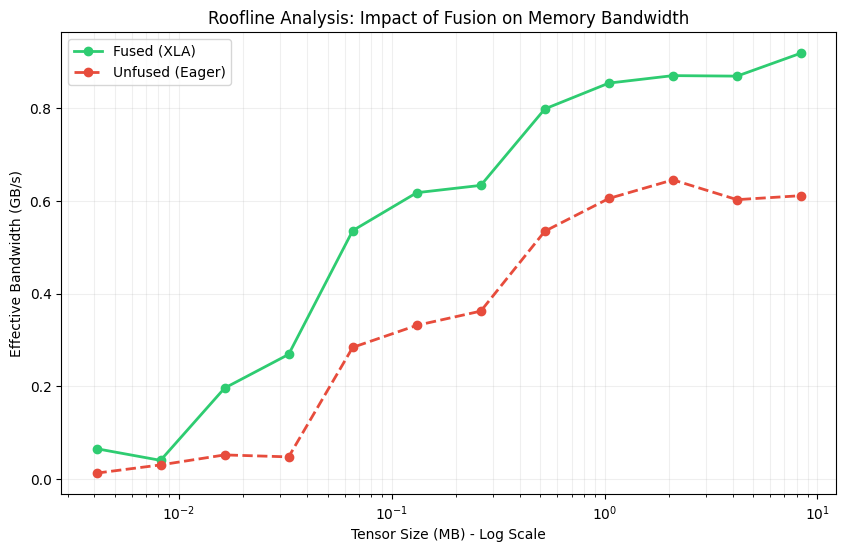


--- Verifying Kernel Fusion ---
Fusion instruction confirmed in HLO.


In [2]:
import jax
import jax.numpy as jnp
import time
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup
# ---------------------------------------------------------
# Define the same memory-bound activation: Tanh -> Sin -> Mul -> Add
def custom_activation(x):
    return jnp.tanh(x) * jnp.sin(x) + (x * 0.5)

jitted_activation = jax.jit(custom_activation)

# 2. Define the Sweep (The "Silicon" Flex)
# ---------------------------------------------------------
# We sweep from small (cache-resident) to large (HBM-bound) sizes.
# Sizes: 1K, 4K, ... up to ~16M elements
sizes = [1024 * (2**i) for i in range(12)]
results = {'size_mb': [], 'eager_bw': [], 'jit_bw': []}

print(f"{'Size (MB)':<12} | {'Eager (GB/s)':<15} | {'Fused (GB/s)':<15} | {'Speedup':<10}")
print("-" * 65)

for n_elements in sizes:
    # Approximate square matrix for consistent shape
    dim = int(np.sqrt(n_elements))
    shape = (dim, dim)

    # Generate data
    x = jax.random.normal(jax.random.key(0), shape)

    # Calculate Data Volume (Read + Write)
    # Float32 = 4 bytes. We read x (4 bytes) and write result (4 bytes).
    # Note: In eager, we read/write intermediate results too, but we calculate
    # "Effective Bandwidth" based on the theoretical minimum I/O.
    total_bytes = (n_elements * 4) * 2

    # --- Benchmark Eager ---
    # Warmup
    _ = custom_activation(x).block_until_ready()

    start = time.time()
    for _ in range(5): # Average over 5 runs
        _ = custom_activation(x).block_until_ready()
    avg_time_eager = (time.time() - start) / 5

    # --- Benchmark JIT ---
    # Warmup
    _ = jitted_activation(x).block_until_ready()

    start = time.time()
    for _ in range(20): # More runs for JIT to stabilize
        _ = jitted_activation(x).block_until_ready()
    avg_time_jit = (time.time() - start) / 20

    # Calculate Bandwidth
    bw_eager = (total_bytes / avg_time_eager) / 1e9 # GB/s
    bw_jit = (total_bytes / avg_time_jit) / 1e9     # GB/s

    # Log results
    size_mb = (n_elements * 4) / 1e6
    results['size_mb'].append(size_mb)
    results['eager_bw'].append(bw_eager)
    results['jit_bw'].append(bw_jit)

    print(f"{size_mb:<12.2f} | {bw_eager:<15.2f} | {bw_jit:<15.2f} | {avg_time_eager/avg_time_jit:<10.2f}")

# 3. Visualization
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(results['size_mb'], results['jit_bw'], 'o-', label='Fused (XLA)', color='#2ecc71', linewidth=2)
plt.plot(results['size_mb'], results['eager_bw'], 'o--', label='Unfused (Eager)', color='#e74c3c', linewidth=2)

plt.xscale('log')
plt.xlabel('Tensor Size (MB) - Log Scale')
plt.ylabel('Effective Bandwidth (GB/s)')
plt.title('Roofline Analysis: Impact of Fusion on Memory Bandwidth')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.show()

# 4. HLO Check (The final verification)
# ---------------------------------------------------------
# Just grabbing the last size to prove fusion happened
print("\n--- Verifying Kernel Fusion ---")
hlo = jitted_activation.lower(x).compile().as_text()
if "fusion" in hlo:
    print("Fusion instruction confirmed in HLO.")